<a href="https://colab.research.google.com/github/aml7hawaiiedu/CCAPLandCoverProject/blob/main/Train_Valid_split_CCAP_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio scikit-image tensorflow keras gdown
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.1 MB/s eta 0:00:00


In [40]:
import rasterio
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import os
import glob
import os
import gdown
import zipfile
from skimage.transform import resize
from tensorflow.keras import layers
import random
from keras.utils import to_categorical
from skimage.util import random_noise
from scipy import ndimage
from scipy.ndimage import label as nd_label
import cv2
from scipy.ndimage import generic_filter
from keras.models import load_model
from scipy.stats import mode
import glob
import os
import cv2
import numpy as np
import rasterio
from keras.utils import Sequence, to_categorical
import rasterio.plot
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# Additional code can be added here if needed

In [4]:
# make a new folder
os.mkdir('/content/image_chips')

In [5]:
# Get all .zip files
zip_files = glob.glob('/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/*.zip')

# direct to the new folder
destination_path = '/content/image_chips/'

for zip_file in zip_files:
    # Get the base name of the zip file (without .zip extension)
    base_name = os.path.basename(zip_file)[:-4]

    # Create a new directory for this zip file
    unzip_dir = os.path.join(destination_path, base_name)
    os.makedirs(unzip_dir, exist_ok=True)

    # Unzip into the specific directory
    !unzip -q "$zip_file" -d "$unzip_dir"

warning [/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Niihau_subset.zip]:  zipfile is empty
warning [/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/Lanai_subset.zip]:  zipfile is empty


In [7]:
# Get all .csv files
csv_files = glob.glob('/content/drive/MyDrive/wetland_unet/UNET_Image_Chips/imagechip_trainingdata/*.csv')


csv_list = []
for csv_file in csv_files:
    # Get the base name of the zip file (without .zip extension)
    base_name = os.path.basename(csv_file)[:-4]

    csv_loc = os.path.join(destination_path, base_name)
    base_csv = pd.read_csv(csv_file)
    base_csv['subset'] = base_name
    csv_list.append(base_csv)


index_csv = pd.concat(csv_list, ignore_index=True)

In [8]:
# make a new folder
os.mkdir('/content/index')

# Define the path for the CSV file
csv_output_path = '/content/index/index.csv'

# Export the DataFrame to a CSV file
index_csv.to_csv(csv_output_path, index=False)

print(f'DataFrame exported to {csv_output_path}')

DataFrame exported to /content/index/index.csv


In [9]:
# Compute total sum of percent values for each label
print(index_csv.groupby('label')['percent'].sum())

label
13    339.165585
14     80.866539
15     26.158833
16      5.413750
17      3.640327
18      4.082653
Name: percent, dtype: float64


In [10]:
# Group by label and count the number of occurances of each label
# how many rows are associated with each label in the index?
print(index_csv.groupby('label')['percent'].count())

label
13    1431
14    1117
15    1285
16     199
17     205
18     170
Name: percent, dtype: int64


In [13]:
# Compute the average percent value of each label category. Useful for calculating some kind of weighted average, or average per category
index_csv.groupby('label')['percent'].sum()/index_csv.groupby('label')['percent'].count()

label
13    0.237013
14    0.072396
15    0.020357
16    0.027205
17    0.017758
18    0.024016
Name: percent, dtype: float64

In [14]:
index_csv

,x_end,y_end,x_org,y_org,id,xmin,xmax,ymin,ymax,label,percent,tif_name,subset
0,9217,1025,8705,513,61,438833.983073,440062.758637,2.457574e+06,2.458802e+06,13,0.000919,8705_513.tif,Kauai10_subset
1,9729,1025,9217,513,62,440062.834396,441291.605845,2.457574e+06,2.458802e+06,13,0.033161,9217_513.tif,Kauai10_subset
2,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,13,0.000130,13313_513.tif,Kauai10_subset
3,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,14,0.000137,13313_513.tif,Kauai10_subset
4,13825,1025,13313,513,70,449893.209832,451122.010258,2.457574e+06,2.458802e+06,15,0.003502,13313_513.tif,Kauai10_subset
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4402,1537,1025,1025,513,26,703456.408765,704685.207789,2.313662e+06,2.314891e+06,15,0.000828,1025_513.tif,Lanai_subset
4403,1537,1025,1025,513,26,703456.420411,704685.233874,2.313662e+06,2.314891e+06,15,0.000828,1025_513.tif,Lanai11_subset
4404,7169,5121,6657,4609,221,716973.164648,718201.965448,2.303832e+06,2.305061e+06,15,0.001396,6657_4609.tif,Lanai11_subset
4405,7681,8705,7169,8193,383,718201.993245,719430.775154,2.295230e+06,2.296459e+06,15,0.001637,7169_8193.tif,Lanai11_subset


In [16]:
index_csv.groupby(['tif_name', 'subset']).size().reset_index(name='Count')

,tif_name,subset,Count
0,10241_10241.tif,Oahu11_subset,1
1,10241_1025.tif,Kauai10_subset,2
2,10241_1025.tif,Kauai_subset,2
3,10241_10753.tif,Maui10_subset,2
4,10241_10753.tif,Maui_subset,2
...,...,...,...
2350,9729_7681.tif,Oahu_subset,1
2351,9729_8193.tif,Kauai10_subset,1
2352,9729_8193.tif,Kauai_subset,1
2353,9729_9729.tif,Oahu11_subset,2


In [30]:
# simple random sample

from sklearn.model_selection import train_test_split

# Define your features (X) and the target variable (y)
sX = index_csv[['tif_name', 'subset']]  # Your independent variables
sy = index_csv['label']  # Your dependent variable

# Split the data into training (70%) and validation (30%) sets
sX_train, sX_val, sy_train, sy_val = train_test_split(sX, sy, test_size=0.3, random_state=42)

# Now, sX_train and sy_train contain your training data, and sX_val and sy_val contain your validation data.

In [31]:
print("sX_train shape:", sX_train.shape)
print("sy_train shape:", sy_train.shape)
print("sX_val shape:", sX_val.shape)
print("sy_val shape:", sy_val.shape)


sX_train shape: (3084, 2)
sy_train shape: (3084,)
sX_val shape: (1323, 2)
sy_val shape: (1323,)


In [32]:
print("sX_train sample:")
print(sX_train.head())

print("sy_train sample:")
print(sy_train.head())

print("sX_val sample:")
print(sX_val.head())

print("sy_val sample:")
print(sy_val.head())


sX_train sample:
            tif_name            subset
557   7681_12801.tif    Kauai10_subset
1837   7681_6657.tif  Molokai10_subset
3544  18433_9217.tif       Oahu_subset
218   20481_5633.tif    Kauai10_subset
2366  19969_8705.tif       Maui_subset
sy_train sample:
557     15
1837    13
3544    13
218     13
2366    15
Name: label, dtype: int64
sX_val sample:
             tif_name          subset
3790  11265_16385.tif     Oahu_subset
668    20993_3073.tif  Molokai_subset
2515  10241_11265.tif     Maui_subset
478   13825_11265.tif  Kauai10_subset
530    6145_12289.tif  Kauai10_subset
sy_val sample:
3790    17
668     15
2515    13
478     13
530     13
Name: label, dtype: int64


In [33]:
print("Class distribution in sy_train:")
print(sy_train.value_counts())

print("Class distribution in sy_val:")
print(sy_val.value_counts())


Class distribution in sy_train:
13    1000
15     892
14     775
17     155
16     151
18     111
Name: label, dtype: int64
Class distribution in sy_val:
13    431
15    393
14    342
18     59
17     50
16     48
Name: label, dtype: int64


In [34]:
# stratified random sample

# Define your features (X) and the target variable (y)
X = index_csv[['tif_name', 'subset']]  # Your independent variables
y = index_csv['label']  # Your dependent variable

# Split the data into training (70%) and validation (30%) sets with stratified sampling
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Now, X_train and y_train contain your training data, and X_val and y_val contain your validation data.

In [35]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (3084, 2)
y_train shape: (3084,)
X_val shape: (1323, 2)
y_val shape: (1323,)


In [36]:
print("Sample of X_train:")
print(X_train.head())

print("Sample of y_train:")
print(y_train.head())

print("Sample of X_val:")
print(X_val.head())

print("Sample of y_val:")
print(y_val.head())

Sample of X_train:
             tif_name          subset
2282   20993_6657.tif     Maui_subset
587   17921_13313.tif  Kauai10_subset
2238    4609_6145.tif     Maui_subset
3499    4097_6657.tif     Oahu_subset
530    6145_12289.tif  Kauai10_subset
Sample of y_train:
2282    14
587     18
2238    14
3499    14
530     13
Name: label, dtype: int64
Sample of X_val:
             tif_name         subset
3592  18945_11265.tif    Oahu_subset
3872   9729_18433.tif    Oahu_subset
1518   5633_12289.tif   Kauai_subset
3692  12801_14849.tif    Oahu_subset
3258  28673_12289.tif  Maui10_subset
Sample of y_val:
3592    13
3872    13
1518    13
3692    16
3258    14
Name: label, dtype: int64


In [37]:
print("Class distribution in y_train:")
print(y_train.value_counts())

print("Class distribution in y_val:")
print(y_val.value_counts())

Class distribution in y_train:
13    1001
15     899
14     782
17     144
16     139
18     119
Name: label, dtype: int64
Class distribution in y_val:
13    430
15    386
14    335
17     61
16     60
18     51
Name: label, dtype: int64


In [38]:
print(X_train.describe())
print(y_train.describe())

              tif_name          subset
count             3084            3084
unique             948              12
top     19969_8193.tif  Kauai10_subset
freq                17             482
count    3084.000000
mean       14.351492
std         1.308048
min        13.000000
25%        13.000000
50%        14.000000
75%        15.000000
max        18.000000
Name: label, dtype: float64


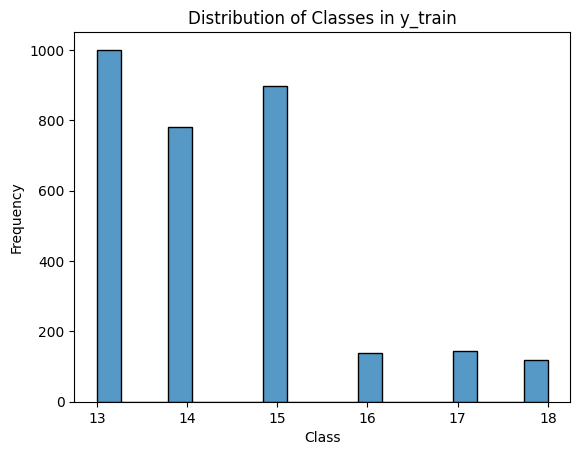

In [39]:


# Example: Plot a histogram of target variable
sns.histplot(y_train)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Distribution of Classes in y_train")
plt.show()